## Composition data
- get the composition and band gap data
- we use the **full** composition as a representation of the compound, 
for the same **full** composition, we take the value which most close to the average value of the band gap in this type compound.

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/Band-gap-predict/Data'

In [3]:
data_df = pd.read_csv('./mp_eda_data.csv')

In [4]:
# get the composition and bandgap data
mp_df = data_df[['composition', 'band_gap']]

In [6]:
# transform the composition_str column to composition column
from matminer.featurizers.conversions import StrToComposition

stc = StrToComposition(target_col_id='composition_type')
mp_trans_df = stc.featurize_dataframe(mp_df, 'composition', ignore_errors=True)

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
StrToComposition: 100%|██████████| 58919/58919 [00:15<00:00, 3799.08it/s]


In [7]:
mp_trans_df.head()

,composition,band_gap,composition_type
0,Ac2 O3,3.5226,"(Ac, O)"
1,Ac16 S24,2.2962,"(Ac, S)"
2,Ac4 S6,3.0275,"(Ac, S)"
3,Ac1 Ag1 Te2,0.0794,"(Ac, Ag, Te)"
4,Ac1 Al1 O3,4.1024,"(Ac, Al, O)"


In [8]:
mp_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58919 entries, 0 to 58918
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   composition       58919 non-null  object 
 1   band_gap          58919 non-null  float64
 2   composition_type  58919 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.3+ MB


In [9]:
mp_trans_df['composition'] = mp_trans_df['composition_type']

In [11]:
mp_trans_df.drop(columns=['composition_type'], inplace=True)
mp_trans_df.head()

,composition,band_gap
0,"(Ac, O)",3.5226
1,"(Ac, S)",2.2962
2,"(Ac, S)",3.0275
3,"(Ac, Ag, Te)",0.0794
4,"(Ac, Al, O)",4.1024


In [12]:
len(mp_trans_df['composition'].unique())

46066

**For the same full_composition datas, we use the following strategy:**
- Calculate the average band gap for each same full_composition.
- Find the item whose band gap is closest to the average band gap for each same full_composition.
- Use these representative items as our composition data.

In [13]:
# 1. caculate the average band gap
avg_band_gaps = mp_trans_df.groupby('composition')['band_gap'].mean().to_dict()

In [14]:
# 2. define function to the closest band gap items
def get_closest_to_avg(name, group):
    avg = avg_band_gaps[name]
    group['diff_from_avg'] = abs(group['band_gap'] - avg)
    idx = group['diff_from_avg'].idxmin()
    return group.loc[idx]

In [15]:
selected_rows = []
# 3. apply the function to each group
for name, group in mp_trans_df.groupby('composition'):
    if len(group) == 1:
        selected_rows.append(group.iloc[0])
    else:
        # get the closest to the average band gap
        selected_row = get_closest_to_avg(name, group)
        selected_rows.append(selected_row)

# 4. create a new DataFrame with the selected rows
representative_df = pd.DataFrame(selected_rows)
# display the results
print(f"original datasets size: {len(mp_trans_df)}")
print(f"datasets size after processed: {len(representative_df)}")
print(f"reduced {len(mp_trans_df) - len(representative_df)} repeated items")

original datasets size: 58919
datasets size after processed: 46066
reduced 12853 repeated items


In [16]:
representative_df = representative_df[['composition', 'band_gap']].reset_index(drop=True)

In [17]:
representative_df.head()

,composition,band_gap
0,(F),2.8962
1,(O),1.3227
2,(O),0.4643
3,"(O, F)",2.1241
4,(O),2.2850


In [18]:
mp_df = representative_df

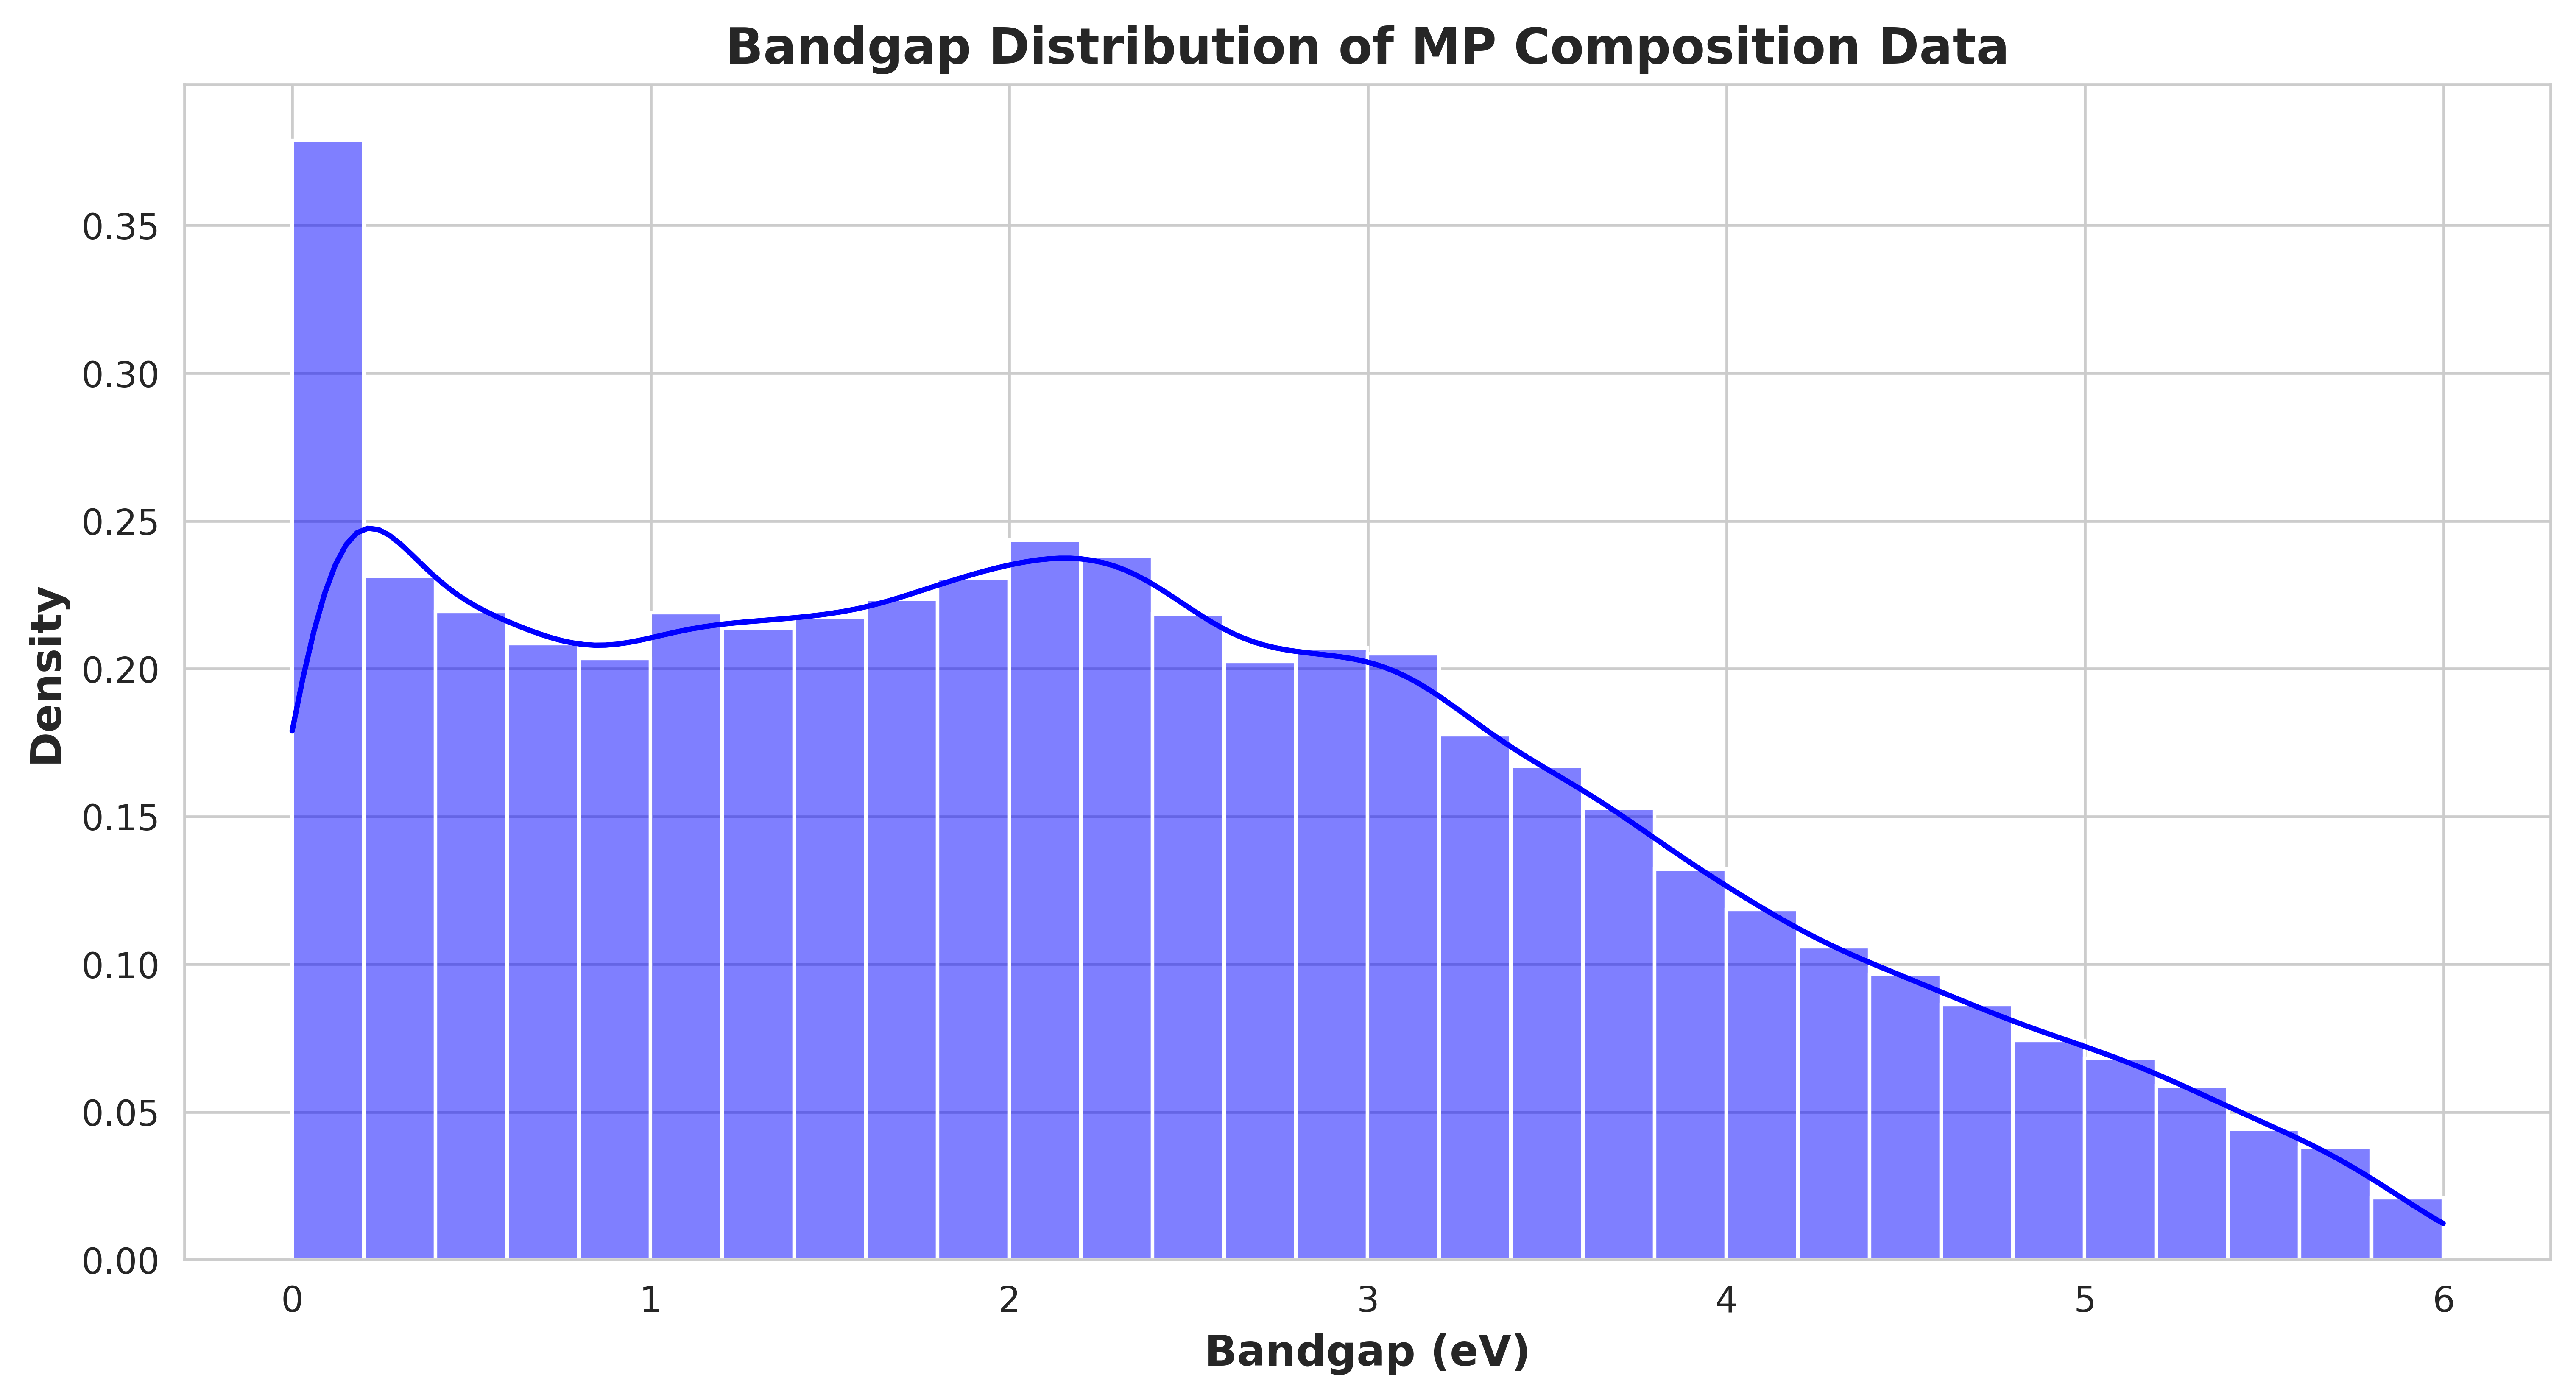

In [21]:
# draw a distribution plot of the bandgap

plt.figure(figsize=(12, 6), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("Set3")  # Set3, RdBu
sns.histplot(mp_df['band_gap'], kde=True, bins=30, color='blue', stat='density')
plt.title("Bandgap Distribution of MP Composition Data", fontsize=14, weight="bold")
plt.xlabel("Bandgap (eV)", fontsize=12, weight="bold")
plt.ylabel("Density", fontsize=12, weight="bold")

# save the figure
# Create the directory if it doesn't exist
save_dir = os.path.join(current_dir, 'figures', 'composition_data_figs')
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, 'mp_bandgap_distribution.png'), dpi=300)
plt.show()

In [22]:
mp_df['composition'] = mp_df['composition'].apply(lambda x: str(x).replace(" ", ""))
mp_df.head()

,composition,band_gap
0,F4,2.8962
1,O2,1.3227
2,O4,0.4643
3,O4F8,2.1241
4,O8,2.2850


In [23]:
# Save the data of composition and band_gap to a csv file
file_path = os.path.join(current_dir, '../Data/composition_data/mp_band_gap.csv')
mp_df.to_csv(file_path, index=False)

## AFLOW Data

In [24]:
# read the data from the csv file
file_path = os.path.join(current_dir, '../Data/aflow_data.csv')
aflow_df = pd.read_csv(file_path)
aflow_df.rename(columns={'formula': 'composition', 'target': 'band_gap'}, inplace=True)
aflow_df.head()

,composition,band_gap
0,Ac2Br6,4.1084
1,Ac2Cl6,5.0778
2,Ac2O3,3.5216
3,Ag10O8P2Se2,0.8118
4,Ag10O8P2Te2,0.9687


In [25]:
aflow_df.describe()

,band_gap
count,13969.000000
mean,2.490380
std,1.585419
min,0.082500
25%,1.254500
50%,2.257500
75%,3.481700
max,17.572733


In [26]:
# get rid of the data that the bandgap is greater than 6eV
aflow_df = aflow_df[aflow_df['band_gap'] < 6]
aflow_df.describe()

,band_gap
count,13626.000000
mean,2.379711
std,1.431261
min,0.082500
25%,1.232925
50%,2.206150
75%,3.384350
max,5.997500


In [27]:
aflow_trans_df = stc.featurize_dataframe(aflow_df, 'composition', ignore_errors=True)

StrToComposition: 100%|██████████| 13626/13626 [00:04<00:00, 2962.73it/s]



In [28]:
aflow_trans_df['composition'] = aflow_trans_df['composition_type']
aflow_trans_df.drop(columns=['composition_type'], inplace=True)
len(aflow_trans_df['composition'].unique())

13626

In [29]:
aflow_trans_df.head()

,composition,band_gap
0,"(Ac, Br)",4.1084
1,"(Ac, Cl)",5.0778
2,"(Ac, O)",3.5216
3,"(Ag, O, P, Se)",0.8118
4,"(Ag, O, P, Te)",0.9687


In [30]:
# 1. caculate the average band gap
avg_band_gaps = aflow_trans_df.groupby('composition')['band_gap'].mean().to_dict()
selected_rows = []
# 3. apply the function to each group
for name, group in aflow_trans_df.groupby('composition'):
    if len(group) == 1:
        selected_rows.append(group.iloc[0])
    else:
        # get the closest to the average band gap
        selected_row = get_closest_to_avg(name, group)
        selected_rows.append(selected_row)

# 4. create a new DataFrame with the selected rows
representative_df = pd.DataFrame(selected_rows)
# display the results
print(f"original datasets size: {len(aflow_trans_df)}")
print(f"datasets size after processed: {len(representative_df)}")
print(f"reduced {len(aflow_trans_df) - len(representative_df)} repeated items")

original datasets size: 13626
datasets size after processed: 13626
reduced 0 repeated items


In [31]:
representative_df = representative_df[['composition', 'band_gap']].reset_index(drop=True)

In [32]:
representative_df.head()

,composition,band_gap
0,(F),1.763767
1,(O),1.547700
2,(O),1.293300
3,(O),1.398500
4,(O),1.199700


In [33]:
aflow_df = representative_df

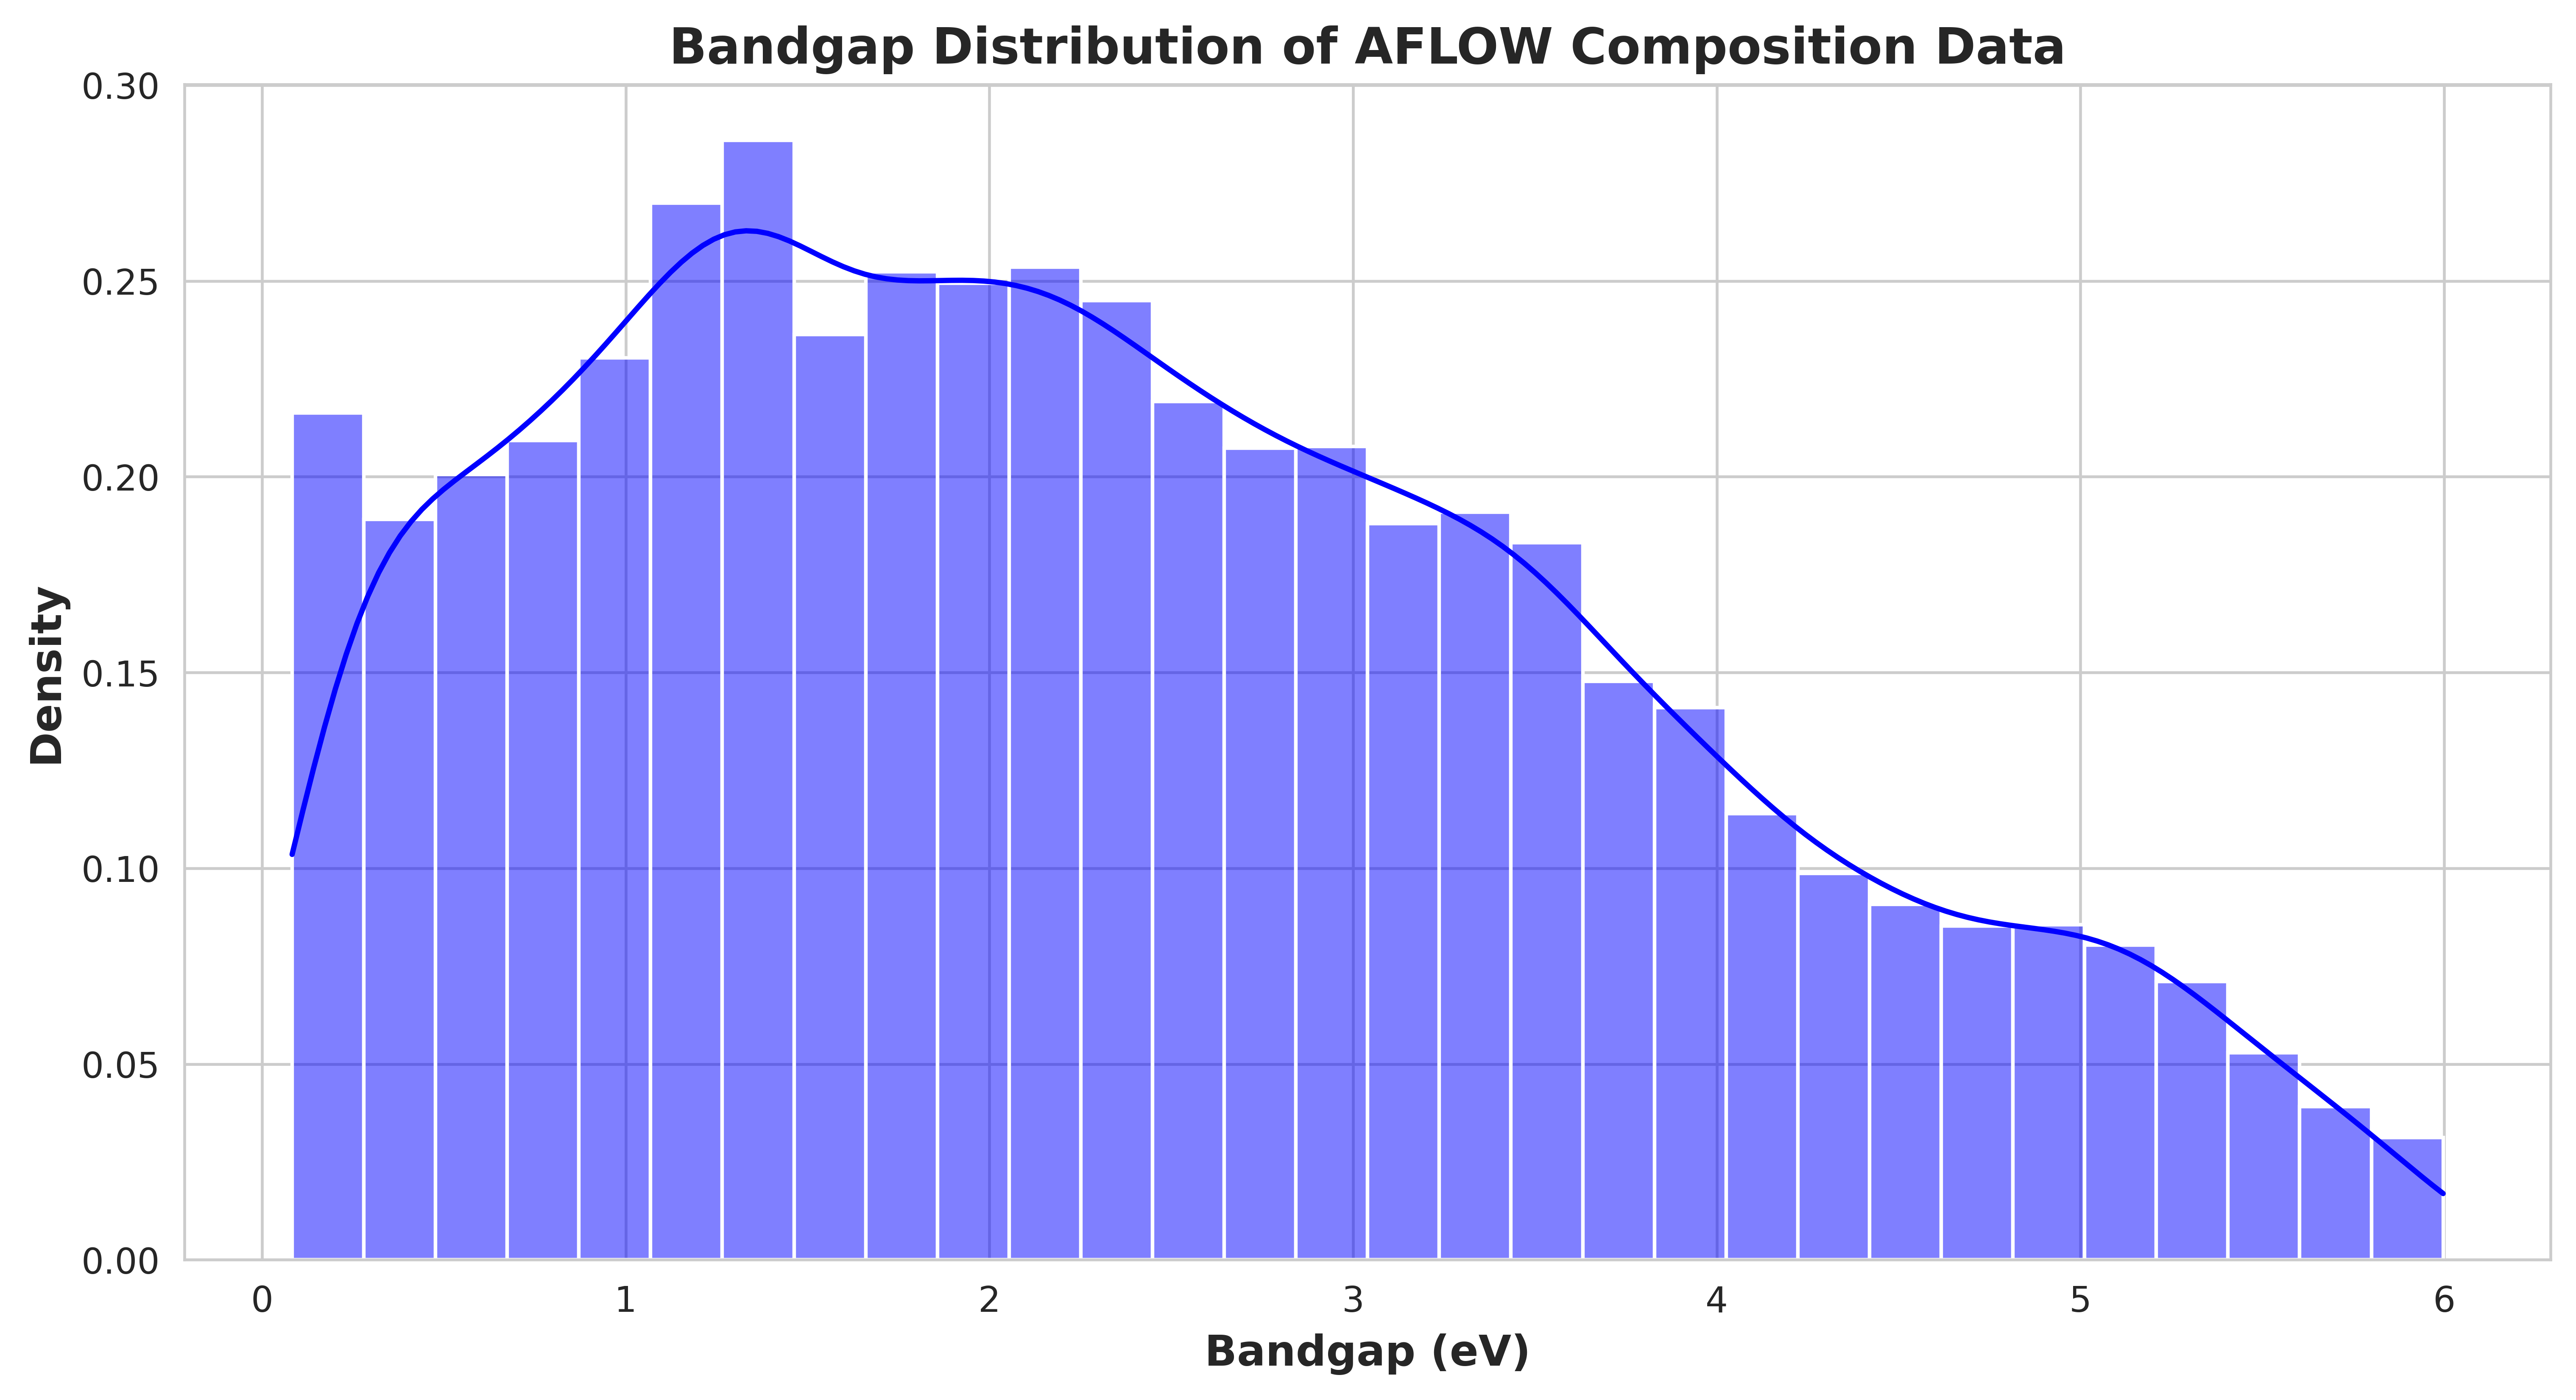

In [34]:
# draw a distribution plot of the bandgap

plt.figure(figsize=(12, 6), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("Set3")  # Set3, RdBu
sns.histplot(aflow_df['band_gap'], kde=True, bins=30, color='blue', stat='density')
plt.title("Bandgap Distribution of AFLOW Composition Data", fontsize=14, weight="bold")
plt.xlabel("Bandgap (eV)", fontsize=12, weight="bold")
plt.ylabel("Density", fontsize=12, weight="bold")

# save the figure
# Create the directory if it doesn't exist
save_dir = os.path.join(current_dir, 'figures', 'composition_data_figs')
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, 'aflow_bandgap_distribution.png'), dpi=300)
plt.show()

In [35]:
aflow_df['composition'] = aflow_df['composition'].apply(lambda x: str(x).replace(" ", ""))
aflow_df.head()

,composition,band_gap
0,F4,1.763767
1,O2,1.547700
2,O6,1.293300
3,O8,1.398500
4,O24,1.199700


In [36]:
# Save the data of composition and band_gap to a csv file
file_path = os.path.join(current_dir, '../Data/composition_data/aflow_band_gap.csv')
aflow_df.to_csv(file_path, index=False)

## Experimental data

In [37]:
# read the data from the csv file
file_path = os.path.join(current_dir, '../Data/Ya Zhuo et data.csv')
exp_df = pd.read_csv(file_path)
exp_df.rename(columns={'Eg (eV)': 'band_gap'}, inplace=True)
exp_df.head()

,composition,band_gap
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


In [38]:
exp_df.describe()

,band_gap
count,6354.000000
mean,1.252225
std,1.539961
min,0.000000
25%,0.000000
50%,0.710000
75%,2.130000
max,11.700000


In [39]:
# remove the mental data that the bandgap is 0eV, we only keep the semiconductors
exp_df = exp_df[exp_df['band_gap'] > 0]
exp_df.describe()

,band_gap
count,3896.000000
mean,2.042259
std,1.501390
min,0.020000
25%,1.000000
50%,1.830000
75%,2.640000
max,11.700000


In [40]:
# get rid of the data that the bandgap is greater than 6eV
exp_df = exp_df[exp_df['band_gap'] < 6]
exp_df.describe()

,band_gap
count,3782.000000
mean,1.882597
std,1.184005
min,0.020000
25%,1.000000
50%,1.800000
75%,2.567500
max,5.980000


In [41]:
exp_trans_df = stc.featurize_dataframe(exp_df, 'composition', ignore_errors=True)

StrToComposition: 100%|██████████| 3782/3782 [00:01<00:00, 3543.08it/s] 



In [42]:
exp_trans_df['composition'] = exp_trans_df['composition_type']
exp_trans_df.drop(columns=['composition_type'], inplace=True)
exp_trans_df.head()

,composition,band_gap
0,"(Hg, Cd, Te)",0.35
1,"(Cu, Br)",3.08
2,"(Lu, P)",1.30
3,"(Cu, Sb, Se)",0.40
4,"(Zn, O)",3.44


In [43]:
exp_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3782 entries, 0 to 3895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   composition  3782 non-null   object 
 1   band_gap     3782 non-null   float64
dtypes: float64(1), object(1)
memory usage: 88.6+ KB


In [44]:
len(exp_trans_df['composition'].unique())

2417

In [45]:
# 1. caculate the average band gap
avg_band_gaps = exp_trans_df.groupby('composition')['band_gap'].mean().to_dict()
selected_rows = []
# 3. apply the function to each group
for name, group in exp_trans_df.groupby('composition'):
    if len(group) == 1:
        selected_rows.append(group.iloc[0])
    else:
        # get the closest to the average band gap
        selected_row = get_closest_to_avg(name, group)
        selected_rows.append(selected_row)

# 4. create a new DataFrame with the selected rows
representative_df = pd.DataFrame(selected_rows)
# display the results
print(f"original datasets size: {len(exp_trans_df)}")
print(f"datasets size after processed: {len(representative_df)}")
print(f"reduced {len(exp_trans_df) - len(representative_df)} repeated items")

original datasets size: 3782
datasets size after processed: 2417
reduced 1365 repeated items


In [46]:
representative_df = representative_df[['composition', 'band_gap']].reset_index(drop=True)
representative_df.head()

,composition,band_gap
0,"(Se, S)",1.90
1,"(C, Br)",3.70
2,"(C, I)",2.26
3,"(W, O)",2.80
4,"(W, Se)",1.45


In [47]:
exp_df = representative_df

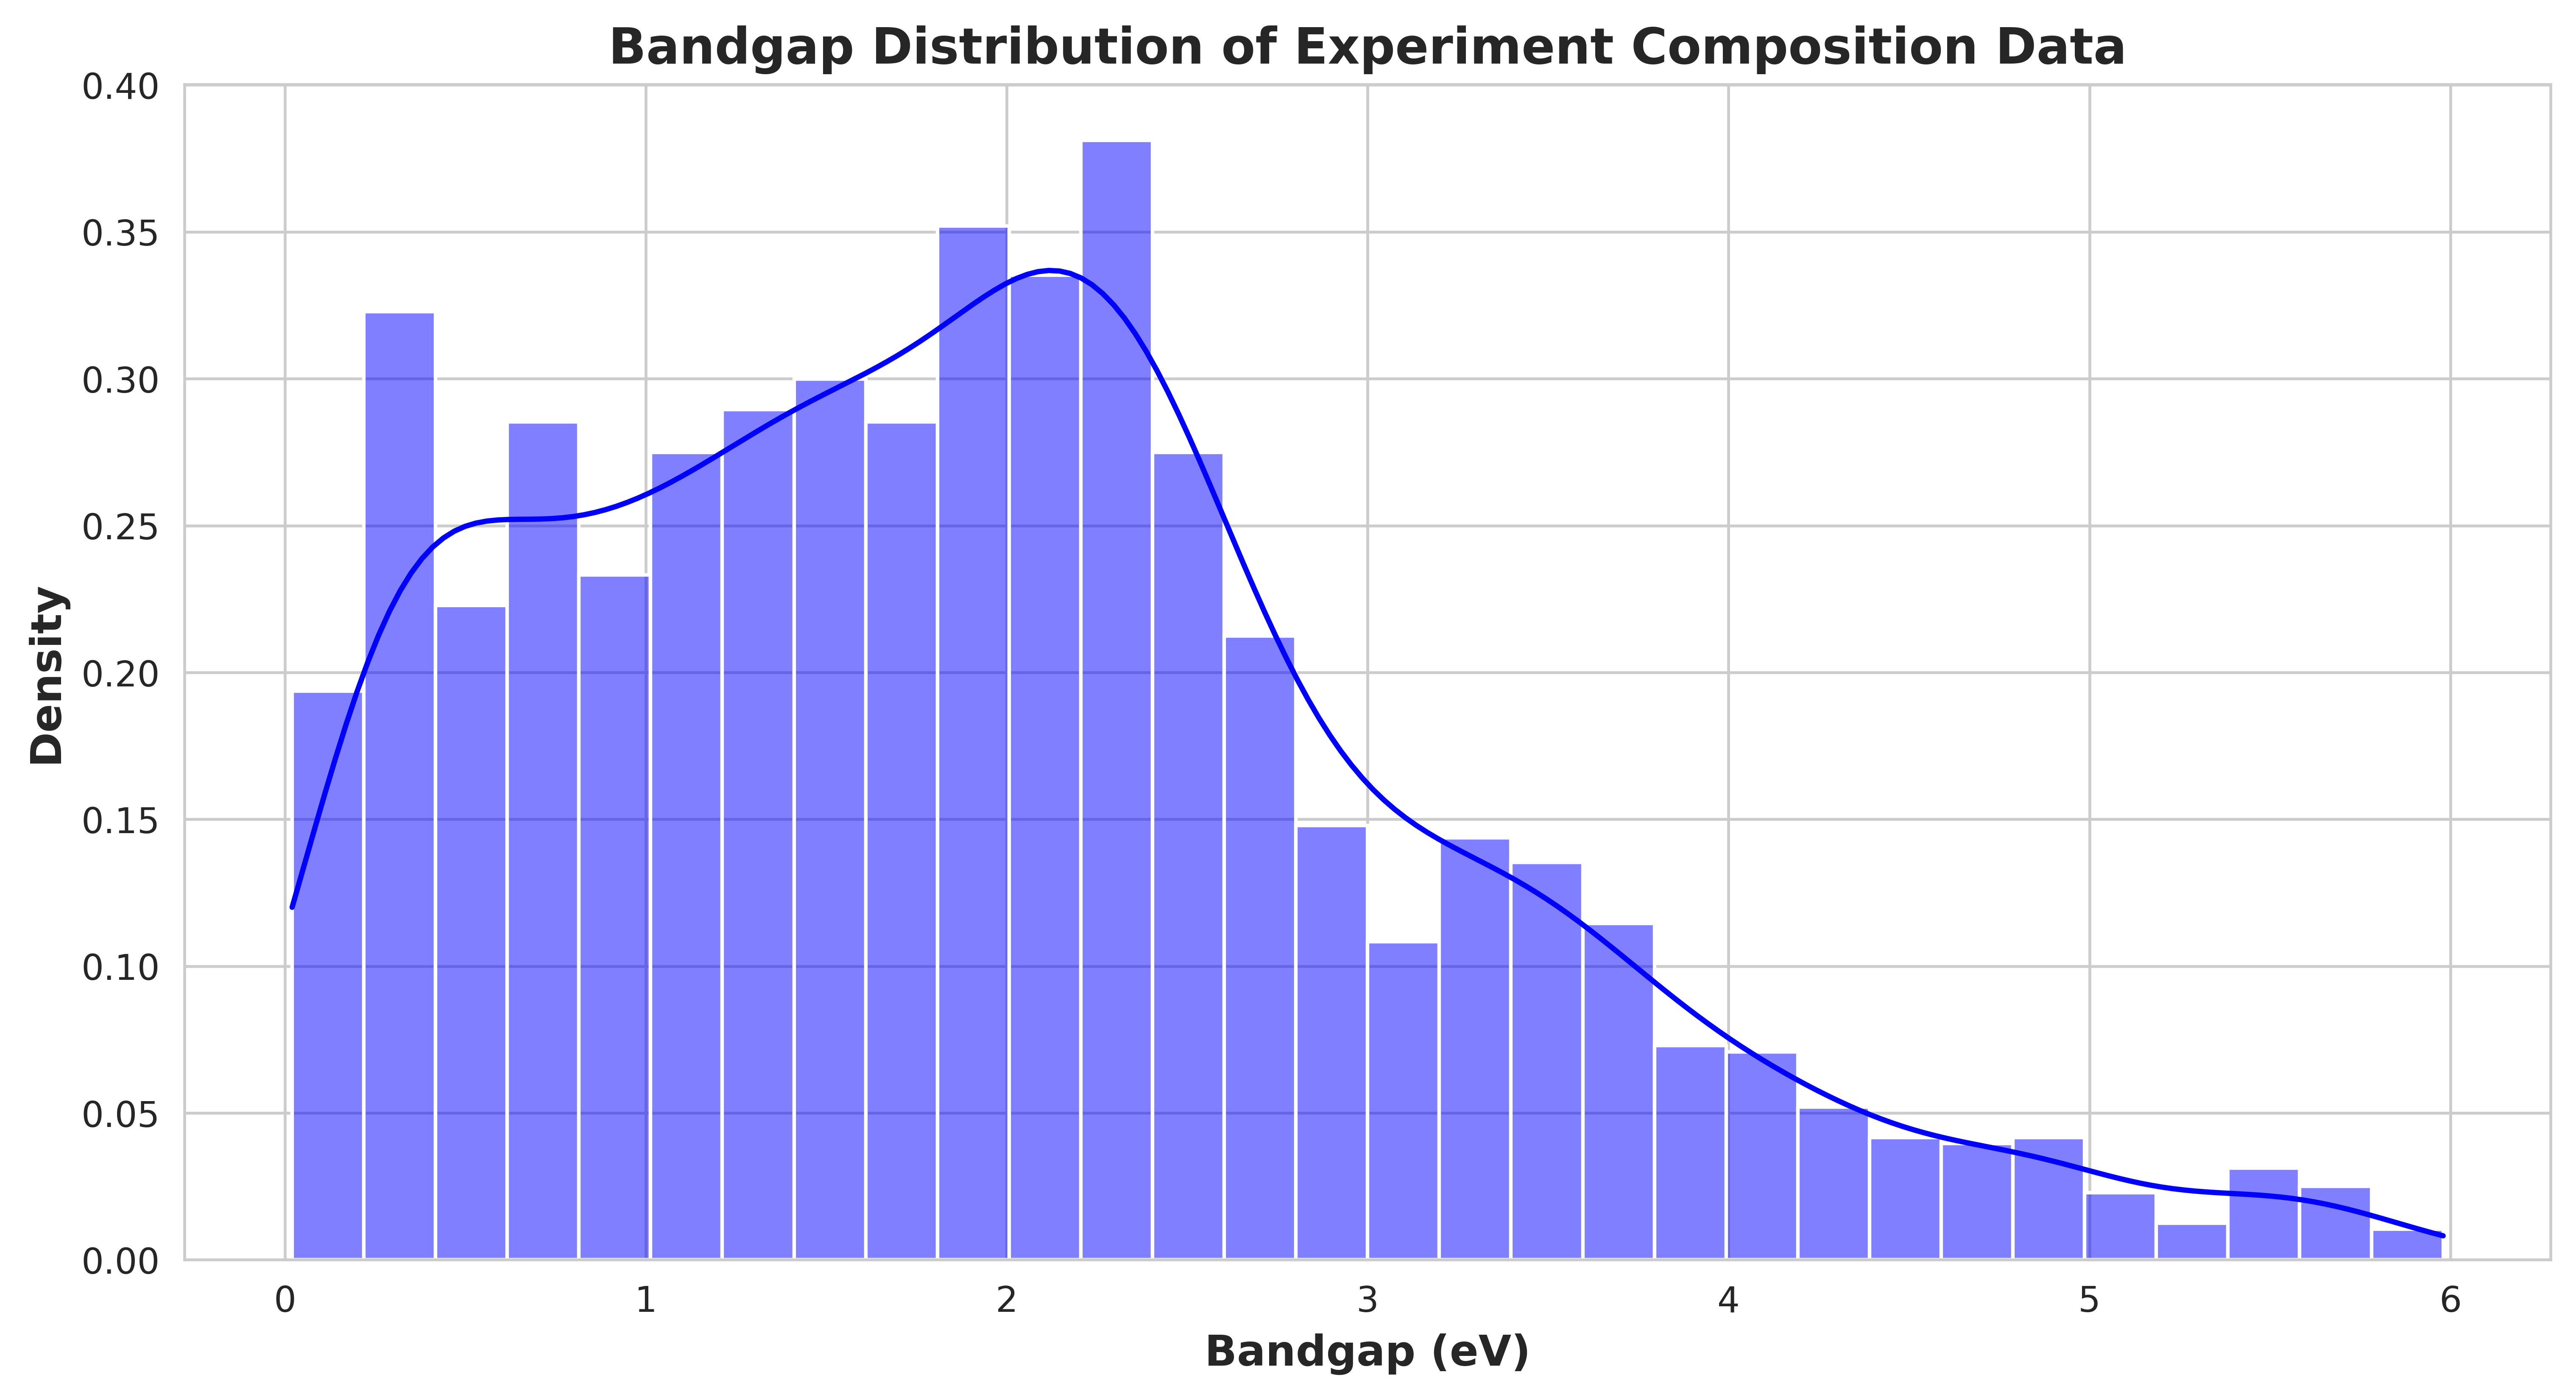

In [48]:
# draw a distribution plot of the bandgap

plt.figure(figsize=(12, 6), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("Set3")  # Set3, RdBu
sns.histplot(exp_df['band_gap'], kde=True, bins=30, color='blue', stat='density')
plt.title("Bandgap Distribution of Experiment Composition Data", fontsize=14, weight="bold")
plt.xlabel("Bandgap (eV)", fontsize=12, weight="bold")
plt.ylabel("Density", fontsize=12, weight="bold")

# save the figure
# Create the directory if it doesn't exist
save_dir = os.path.join(current_dir, 'figures', 'composition_data_figs')
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, 'exp_bandgap_distribution.png'), dpi=300)
plt.show()

In [49]:
exp_df['composition'] = exp_df['composition'].apply(lambda x: str(x).replace(" ", ""))
exp_df.head()

,composition,band_gap
0,Se1S1,1.90
1,C1Br4,3.70
2,C1I4,2.26
3,W1O3,2.80
4,W1Se2,1.45


In [50]:
# Save the data of composition and band_gap to a csv file
file_path = os.path.join(current_dir, '../Data/composition_data/exp_band_gap.csv')
exp_df.to_csv(file_path, index=False)